In [ ]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.develop("QuantumDots")
Pkg.add("DifferentialEquations")
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
using DifferentialEquations

In [73]:
struct MajoranaWrapper{B,D}
    basis::B
    majoranas::D
    function MajoranaWrapper(basis, labels=collect(Base.product(keys(basis), (:a, :b))))
        N = length(basis)
        length(labels) == 2 * N || throw(ErrorException("Number of majoranas is not twice the fermion number"))
        majA = map(f -> f + f', basis)
        majB = map(f -> 1im * (f - f'), basis)
        majs = vcat(majA, majB)
        dA = QuantumDots.dictionary(zip(labels[1:N], values(majA)))
        dB = QuantumDots.dictionary(zip(labels[N+1:2N], values(majB)))
        d = merge(dA, dB)
        new{typeof(basis),typeof(d)}(basis, d)
    end
end

Base.getindex(g::MajoranaWrapper, i...) = g.majoranas[i...]

In [194]:
c = FermionBasis(1:3)
γ = MajoranaWrapper(c, 0:5)

MajoranaWrapper{FermionBasis{3, Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}, QuantumDots.NoSymmetry}, Dictionaries.Dictionary{Int64, SparseArrays.SparseMatrixCSC{Tv, Int64} where Tv}}(FermionBasis{3,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.NoSymmetry}:
keys = {1, 2, 3}, {0 = sparse([2, 1, 4, 3, 6, 5, 8, 7], [1, 2, 3, 4, 5, 6, 7, 8], [1, 1, -1, -1, -1, -1, 1, 1], 8, 8), 1 = sparse([3, 4, 1, 2, 7, 8, 5, 6], [1, 2, 3, 4, 5, 6, 7, 8], [1, 1, 1, 1, -1, -1, -1, -1], 8, 8), 2 = sparse([5, 6, 7, 8, 1, 2, 3, 4], [1, 2, 3, 4, 5, 6, 7, 8], [1, 1, 1, 1, 1, 1, 1, 1], 8, 8), 3 = sparse([2, 1, 4, 3, 6, 5, 8, 7], [1, 2, 3, 4, 5, 6, 7, 8], Complex{Int64}[0 - 1im, 0 + 1im, 0 + 1im, 0 - 1im, 0 + 1im, 0 - 1im, 0 - 1im, 0 + 1im], 8, 8), 4 = sparse([3, 4, 1, 2, 7, 8, 5, 6], [1, 2, 3, 4, 5, 6, 7, 8], Complex{Int64}[0 - 1im, 0 - 1im, 0 + 1im, 0 + 1im, 0 + 1im, 0 + 1im, 0 - 1im, 0 - 1im], 8, 8), 5 = sparse([5, 6, 7, 8, 1, 2, 3, 4], [1, 2, 3, 4, 5, 6, 7, 8], Complex{Int64}[0 - 1im, 0 -

In [195]:
smooth_step(x, k) = 1 / 2 + tanh(k * x) / 2
# Give the value of the three deltas at time t in the three point majorana braiding protocol
function braiding_deltas(t, T, Δmax, Δmin, k)
    Δ1 = Δtrajectory(t, T, Δmax, Δmin, k)
    Δ2 = Δtrajectory(t + T / 3, T, Δmax, Δmin, k)
    Δ3 = Δtrajectory(t + 2T / 3, T, Δmax, Δmin, k)
    return Δ1, Δ2, Δ3
end
function Δtrajectory(t, T, Δmax, Δmin, k)
    dΔ = Δmax - Δmin
    tp = mod(t, T) - T/12
    Δmin + dΔ * smooth_step(tp - 1T / 6, k) - dΔ * smooth_step(tp - 4T / 6, k)
end

Δtrajectory (generic function with 1 method)

(101, 3)


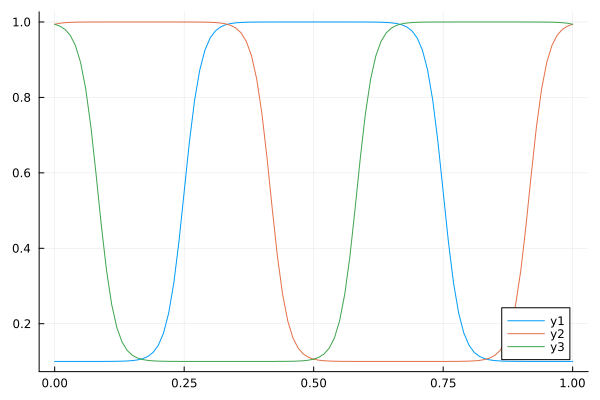

In [196]:
let T = 1, Δmax = 1, Δmin = 0.1, k = 30
    ts =  0:0.01:T
    deltas = stack([braiding_deltas(t, T, Δmax, Δmin, k) for t in ts])'
    println(size(deltas))
    plot(ts,deltas)
end

In [238]:
function H(t, (T,Δmin, Δmax, k))
    Δ1, Δ2, Δ3 = braiding_deltas(t, T, Δmax, Δmin, k)
    Matrix(1im*(Δ1 * γ[0]*γ[1] + Δ2 * γ[0]*γ[2] + Δ3 * γ[0]*γ[3]))
end

H (generic function with 1 method)

In [239]:
function schrödinger!(du, u, p, t)
    ham = 1im .* H(t, p)
    mul!(du, ham, u)
    return du
end
function heisenberg!(du, u, p, t)
    ham = 1im .* H(t, p)
    du .= ham*u .- u*ham
    return du
end

heisenberg! (generic function with 1 method)

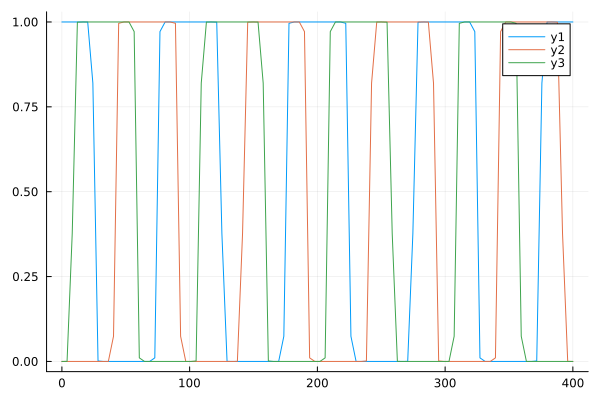

In [287]:
u0 = 1.0complex(Matrix(γ[1]))
T = 100
k = 100/T
Δmin = 0.0001
Δmax = 1
p = (T, Δmin, Δmax, k)
tspan = (0.0, 4T)
prob = ODEProblem(heisenberg!, u0, tspan, p)
ts = range(0, tspan[2], 100)
deltas = stack([braiding_deltas(t, p...) for t in ts])'
plot(ts, deltas)

In [288]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, 3rd order Hermite
t: 671-element Vector{Float64}:
   0.0
   0.2429781085959505
   0.6039380789374705
   1.0057266542155308
   1.4647043486626332
   1.9604216152743899
   2.4945204148020705
   3.0549756489742315
   3.643867159990211
   4.251155639628845
   ⋮
 396.2110677404709
 396.68353907721524
 397.178757866788
 397.65821148399226
 398.1401240674889
 398.62305590796575
 399.09480002154396
 399.574065761316
 400.0
u: 671-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im -4.485960901216998e-5 - 1.1350188285881984e-5im … 0.0 + 0.0im -5.7454984253944536e-18 - 6.649557381492217e-19im; -4.485960901216998e-5 + 1.1350188285881984e-5im 0.0 + 0.0im … -5.7454984253944536e-18 + 6.649557381492217e-19im 0.0 + 0.0im; … 

In [289]:
projs = stack([[abs(tr(γ*sol(t))) for γ in (γ[1],γ[2],γ[3])] for t in ts])';

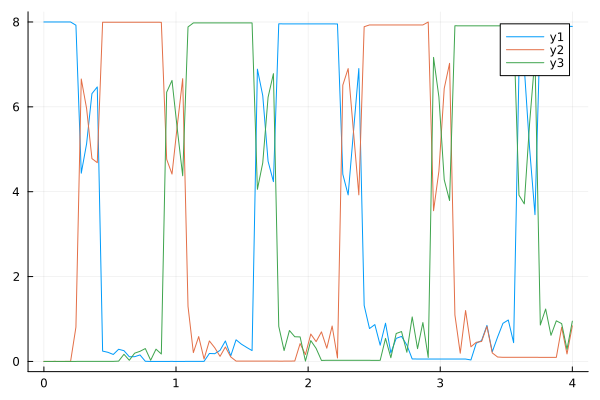

In [290]:
plot(ts ./ T, projs)